# A Model-Agnostic Framework for Natural Language Explanations (NLE) of Predictive Models
**Master's Thesis Experimentation Notebook**

This notebook demonstrates a modular, object-oriented framework designed to translate the outputs of black-box predictive models into human-readable **Natural Language Explanations (NLEs)**.

### Research Hypothesis
The core objective is to evaluate whether injecting **Logic-based (Araucana-XAI)** alongside traditional **Feature Importance (SHAP, LIME)** improves the causal reasoning of Large Language Models (LLMs) and reduces hallucinations.

By comparing a *Baseline* (Feature Weights only) against an *Enhanced Hybrid* (Weights + Decision Tree Logic), we aim to demonstrate that providing explicit structural boundaries allows the LLM to generate more accurate, actionable, and causally grounded medical reports.

---
## 1. Environment Setup & Dependencies
In this section, we install the necessary libraries to run the pipeline. This includes the LLM inference engine (`unsloth` for efficient 4-bit quantized Llama-3 execution) and the Explainable AI (XAI) backends (`shap`, `lime`, and `araucanaxai`).

In [1]:
%%capture
# BLOCK 1: Environment Setup & Dependency Installation
# This block installs the necessary libraries for Symbolic AI (Clingo),
# Explainable AI (SHAP, LIME, Araucana), and LLM inference (Unsloth).

import os
import sys
import warnings

# Suppress minor warnings during installation
warnings.filterwarnings('ignore')

# 1.1 Install Standard XAI Libraries
!pip install shap lime

# 1.2 Install Araucana-XAI (Symbolic Explainer)
!pip install araucanaxai

# 1.3 Install Unsloth and LLM Dependencies
# We install unsloth-zoo first to bypass PyPI checks, then the main library.
try:
    import torch
except ImportError:
    !pip install torch

!pip install --upgrade --no-cache-dir "git+https://github.com/unslothai/unsloth-zoo.git"
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "trl<0.9.0" peft accelerate bitsandbytes

print(">>> Environment Setup Completed Successfully.")

## 2. Clinical Dataset & Black-Box Modeling
To simulate a high-stakes decision environment, we utilize the **Breast Cancer Wisconsin Diagnostic Dataset**.

We train a **Random Forest Classifier** as our surrogate "black-box" model. While Random Forests offer some intrinsic interpretability, their ensemble nature makes local, patient-specific decision paths complex to interpret without external post-hoc explanation tools.

**Pipeline Steps:**
1. Load and split the clinical dataset (80% Train / 20% Test).
2. Train the Random Forest algorithm.
3. Validate baseline accuracy to ensure the model is producing meaningful predictions before we attempt to explain them.

In [2]:
# BLOCK 2: Data Pipeline & Black-Box Model Training
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configuration
RANDOM_SEED = 42

def setup_medical_data():
    """
    Loads the Breast Cancer Wisconsin dataset.
    Returns: X_train, X_test, y_train, y_test, class_names, feature_names
    """
    data = load_breast_cancer()
    df = pd.DataFrame(data.data, columns=data.feature_names)
    df['target'] = data.target

    X = df.drop('target', axis=1)
    y = df['target']

    # Split data (80% Train, 20% Test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED
    )

    return X_train, X_test, y_train, y_test, data.target_names, data.feature_names

# 1. Load Data
print("Loading Medical Dataset...")
X_train, X_test, y_train, y_test, class_names, feature_names = setup_medical_data()

# 2. Train Black-Box Model (Random Forest)
# We use RF as it provides good performance but requires explanation tools (not intrinsically interpretable).
print("Training Random Forest Classifier...")
model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

# 3. Basic Evaluation
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f">>> Model Accuracy: {acc:.4f}")
print(f">>> Class Mapping: 0 = {class_names[0]}, 1 = {class_names[1]}")

Loading Medical Dataset...
Training Random Forest Classifier...
>>> Model Accuracy: 0.9649
>>> Class Mapping: 0 = malignant, 1 = benign


## 3. The NLE Framework Architecture
This section defines the core orchestrator of the project: the `NLEFramework` class.

To ensure modularity and scalability, the framework is designed using Object-Oriented Programming (OOP) principles. It handles the complete pipeline from prediction extraction to prompt generation.

### Key Components:
* **Singleton LLM Manager:** Prevents Out-of-Memory (OOM) errors by caching the Llama-3 model in the GPU. If the framework is re-instantiated, it reuses the existing weights.
* **XAI Wrappers:** Three distinct methods to extract context from the black-box model:
  * `_get_shap_context`: Extracts global feature attribution.
  * `_get_lime_context`: Extracts local linear boundaries.
  * `_get_araucana_context`: Extracts symbolic decision tree paths.


* **Prompt Injection Engine:** Dynamically constructs the input prompt based on the selected explainers and the active persona adapter, strictly hiding the ground truth (`y_true`) from the LLM to ensure objective evaluation.

In [3]:
# BLOCK 3: NLE Framework Definition (Core Logic)
import torch
from unsloth import FastLanguageModel
import shap
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import accuracy_score
import araucanaxai
import warnings
import gc

class NLEFramework:
    """
    Main framework class for generating Natural Language Explanations.
    It integrates a Large Language Model (Llama-3) with multiple XAI backends (SHAP, LIME, Araucana).
    Implements a Singleton pattern to avoid reloading the LLM into GPU memory.
    """

    # Singleton storage to share model across instances
    _loaded_model = None
    _loaded_tokenizer = None

    def __init__(self, llm_model_name="unsloth/llama-3-8b-Instruct", load_in_4bit=True, class_names={0: "Benigno", 1: "Maligno"}):
        print("--- Initializing NLEFramework ---")

        # Memory Management: Check if model is already loaded
        if NLEFramework._loaded_model is not None:
            print(f">>> Memory Optimization: Reusing loaded model '{llm_model_name}'.")
            self.model = NLEFramework._loaded_model
            self.tokenizer = NLEFramework._loaded_tokenizer
        else:
            print(f">>> Loading LLM from scratch: {llm_model_name}...")
            # Clear GPU cache before loading
            gc.collect()
            torch.cuda.empty_cache()

            self.model, self.tokenizer = FastLanguageModel.from_pretrained(
                model_name=llm_model_name,
                max_seq_length=2048,
                dtype=None,
                load_in_4bit=load_in_4bit,
            )
            FastLanguageModel.for_inference(self.model)

            # Cache the model in the class
            NLEFramework._loaded_model = self.model
            NLEFramework._loaded_tokenizer = self.tokenizer
            print(">>> Model loaded and cached.")

        self.adapters = {}
        self.class_names = class_names

    def register_adapter(self, adapter_name, system_prompt, user_template):
        """Registers a prompt template (Adapter) for a specific persona/task."""
        self.adapters[adapter_name] = {"system": system_prompt, "user": user_template}
        print(f"Adapter '{adapter_name}' registered.")

    # --- XAI METHODS ---

    def _get_shap_context(self, black_box_model, X_train, instance, pred_class, plot=True):
        """Generates Feature Importance context using SHAP."""
        explainer = shap.TreeExplainer(black_box_model)
        shap_values_obj = explainer(instance)

        # Handle SHAP output dimensions
        if len(shap_values_obj.shape) == 3:
             shap_values_for_plot = shap_values_obj[:, :, pred_class]
        else:
             shap_values_for_plot = shap_values_obj

        if plot:
            print("\n--- SHAP Plot (Feature Importance) ---")
            plt.figure()
            shap.plots.waterfall(shap_values_for_plot[0], show=False)
            plt.show()

        # Extract text description
        vals = shap_values_for_plot.values[0]
        feature_names = X_train.columns
        feature_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['feature', 'shap_value'])
        feature_importance['abs_value'] = feature_importance['shap_value'].abs()
        feature_importance = feature_importance.sort_values(by='abs_value', ascending=False).head(5)

        context_str = "ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS (SHAP):\n"
        for _, row in feature_importance.iterrows():
            input_val = instance[row['feature']].values[0]
            direction = "AUMENTA" if row['shap_value'] > 0 else "DISMINUYE"
            context_str += f"- La variable '{row['feature']}' (valor={input_val:.2f}) {direction} el riesgo (Impacto: {row['shap_value']:.4f}).\n"
        return context_str

    def _get_lime_context(self, black_box_model, X_train, instance, pred_class, plot=True):
        """Generates Local Weighted Rules using LIME."""
        lime_explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=np.array(X_train),
            feature_names=list(X_train.columns),
            class_names=[self.class_names[0], self.class_names[1]],
            mode='classification',
            discretize_continuous=True
        )
        exp = lime_explainer.explain_instance(
            data_row=instance.values[0],
            predict_fn=black_box_model.predict_proba,
            num_features=5
        )
        if plot:
            print("\n--- LIME Plot (Local Contribution) ---")
            exp.as_pyplot_figure()
            plt.show()

        lime_list = exp.as_list()
        context_str = "ANÁLISIS LIME (Reglas Locales Ponderadas):\n"
        for feature_rule, weight in lime_list:
            direction = "AUMENTA" if weight > 0 else "DISMINUYE"
            context_str += f"- La condición '{feature_rule}' {direction} la probabilidad (Peso: {weight:.4f}).\n"
        return context_str

    def _get_araucana_context(self, black_box_model, X_train, instance, pred_class, plot=True):
        """Generates Symbolic Logic Rules using Araucana XAI."""
        warnings.filterwarnings("ignore")
        feature_names = list(X_train.columns)

        def predict_wrapper(X_numpy):
            if isinstance(X_numpy, pd.DataFrame):
                return black_box_model.predict(X_numpy)
            df_temp = pd.DataFrame(X_numpy, columns=feature_names)
            return black_box_model.predict(df_temp)

        target_instance = instance.values.reshape(1, -1)
        target_pred = predict_wrapper(target_instance)
        cat_mask = [False] * len(feature_names)

        try:
            explanation_tree = araucanaxai.run(
                x_target=target_instance,
                y_pred_target=target_pred,
                x_train=X_train.values,
                feature_names=feature_names,
                cat_list=cat_mask,
                neighbourhood_size=200,
                oversampling='uniform',
                oversampling_size=2000,
                max_depth=3,
                predict_fun=predict_wrapper
            )
            tree_obj = explanation_tree['tree']

            # Fidelity Check (Audit)
            noise = np.random.normal(0, 0.5, (100, X_train.shape[1]))
            X_audit = target_instance + noise
            y_blackbox = predict_wrapper(X_audit)
            y_surrogate = tree_obj.predict(X_audit)
            fidelity_val = accuracy_score(y_blackbox, y_surrogate)

            if plot:
                print(f"\n--- Araucana Plot (Local Logic Tree) ---")
                plt.figure(figsize=(12, 6), dpi=100)
                plot_tree(
                    tree_obj,
                    feature_names=feature_names,
                    class_names=[str(c) for c in black_box_model.classes_],
                    filled=True,
                    rounded=True,
                    fontsize=9
                )
                plt.title(f"Araucana Local Rules (Audited Fidelity: {fidelity_val:.2f})")
                plt.show()

            tree_rules = export_text(tree_obj, feature_names=feature_names)
            context_str = f"ANÁLISIS DE LÓGICA SIMBÓLICA (ARAUCANA):\n"
            context_str += f"Fidelidad del explicador: {fidelity_val:.2f} (Si es bajo, tomar con precaución).\n"
            context_str += "Reglas extraídas:\n" + tree_rules

        except Exception as e:
            print(f"Araucana Error: {e}")
            context_str = "Error al extraer reglas lógicas."

        warnings.resetwarnings()
        return context_str

    # --- MAIN GENERATION METHOD ---

    def generate_explanation(self, black_box_model, X_train, instance, y_true=None, explainer_type="shap", adapter_name="default", plot=True):
        if adapter_name not in self.adapters:
            raise ValueError(f"Adapter '{adapter_name}' not found.")

        # 1. Model Prediction
        prediction_idx = black_box_model.predict(instance)[0]
        pred_label_str = self.class_names.get(prediction_idx, str(prediction_idx))

        # 2. Internal Audit (Displayed to user, HIDDEN from LLM to prevent bias)
        if y_true is not None:
            true_val = y_true.values[0] if hasattr(y_true, 'values') else y_true
            true_label_str = self.class_names.get(true_val, str(true_val))

            if true_val == prediction_idx:
                status_type = "CORRECT"
                detail = "(True Positive)" if prediction_idx == 1 else "(True Negative)"
            else:
                status_type = "INCORRECT (Model Failure)"
                detail = "(False Positive)" if prediction_idx == 1 else "(False Negative)"

            print(f"\n>>> [INTERNAL AUDIT]: Model Prediction: {pred_label_str} | Ground Truth: {true_label_str}")
            print(f">>> STATUS: {status_type} {detail}")
            print(">>> (This ground truth info is HIDDEN from the LLM to evaluate pure explanatory fidelity).")

        # 3. Context Generation (Handling multiple explainers)
        explainers_to_run = explainer_type.split("+")
        combined_context = ""

        for expl in explainers_to_run:
            expl = expl.strip().lower()
            if expl == "shap":
                txt = self._get_shap_context(black_box_model, X_train, instance, prediction_idx, plot=plot)
                combined_context += f"\n--- FUENTE 1: PESO DE VARIABLES (SHAP) ---\n{txt}\n"
            elif expl == "lime":
                txt = self._get_lime_context(black_box_model, X_train, instance, prediction_idx, plot=plot)
                combined_context += f"\n--- FUENTE: REGLAS PONDERADAS (LIME) ---\n{txt}\n"
            elif expl == "araucana":
                txt = self._get_araucana_context(black_box_model, X_train, instance, prediction_idx, plot=plot)
                combined_context += f"\n--- FUENTE 2: ESTRUCTURA LÓGICA (ARAUCANA) ---\n{txt}\n"

        # 4. Prompt Construction
        adapter = self.adapters[adapter_name]
        # NOTE: We do NOT pass 'status_info' to avoid data leakage.
        user_prompt = adapter["user"].format(
            prediction=pred_label_str,
            context_data=combined_context,
            input_features=instance.to_string(index=False)
        )

        # 5. LLM Inference
        messages = [{"role": "system", "content": adapter["system"]}, {"role": "user", "content": user_prompt}]
        inputs = self.tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
        outputs = self.model.generate(inputs, max_new_tokens=600, use_cache=True)
        response = self.tokenizer.batch_decode(outputs)

        return response[0].split("<|start_header_id|>assistant<|end_header_id|>")[-1].replace("<|eot_id|>", "")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Using MoE backend 'grouped_mm'
🦥 Unsloth Zoo will now patch everything to make training faster!


## 4. Prompt Engineering: The Adapter Layer (Standardized)
To ensure experimental rigor, we enforce a **Standardized Prompt Structure** across all conditions. All adapters share the exact same definitions for `SYSTEM ROLE`, `OBJECTIVE`, `CONSTRAINTS`, `TONE & STYLE`, and the critical `HANDLING "BENIGN" CASES` protocol.

The only variable manipulated is the **Narrative Structure**, which dictates *how* the explanation is constructed:

### Set 1: Hybrid Adapters (SHAP + LIME + ARAUCANA)
* **Logic:** "Rule-Based Causality".
* **Narrative Instruction:** The LLM is instructed to identify the "Decisive Rule" or "Checklist" (Araucana) as the causal trigger, using SHAP/LIME only to confirm the intensity of the signal.

### Set 2: Baseline Adapters (SHAP + LIME Only)
* **Logic:** "Weighted Influence".
* **Narrative Instruction:** The LLM is instructed to explain the outcome based on "Cumulative Weights", "Feature Dominance", or "Tipping the Scale". References to logical paths or decision trees are strictly forbidden.

This structural parity ensures that any difference in the quality or hallucination rate of the generated text can be attributed to the **informational content** (Symbols vs. Weights) rather than prompt inconsistencies.

In [4]:
# BLOCK 4: Adapter Configuration (Prompt Engineering)

# ==============================================================================
# 1. COMMON COMPONENTS (Standardized for ALL Prompts)
# ==============================================================================

# A. BENIGN CASE HANDLING (Clinical Safety)
BENIGN_INSTRUCTION = """
HANDLING "BENIGN" CASES
If the prediction is BENIGN: Do not use words like "Risk Factors". Refer to features as "Safety Signals" or "indicators of normalcy".
Example: "The benign classification is supported by low values in cellular perimeter and the absence of concave irregularities."
"""

# B. UNIVERSAL USER TEMPLATE (Single Input Structure)
# Since the input data format is identical for all personas, we use a single template.
# The System Prompt defines HOW to interpret this data.
UNIVERSAL_USER_TEMPLATE = """
PREDICTION: {prediction}

XAI CONTEXT (EVIDENCE):
{context_data}

PATIENT DATA (INPUTS):
{input_features}

Generate the response following the System Role instructions:
"""

# ==============================================================================
# 2. SET 1: HYBRID PROMPTS (SHAP + LIME + ARAUCANA)
# Logic: "Rule-Based Causality" (The Tree/Checklist defined the outcome).
# ==============================================================================

detailed_hybrid_system = f"""SYSTEM ROLE
Act as a Senior Computational Oncologist. Your task is to analyze the output of a predictive AI model and write a technical decision-support report.

OBJECTIVE
Synthesize a causal explanation combining the "Logic Path" (Araucana) with "Feature Importance" (SHAP/LIME).

INPUT DATA
You will receive Prediction, Combined XAI Context, and Patient Data.

{BENIGN_INSTRUCTION}

CONSTRAINTS
- NO LISTS OR BULLET POINTS. Use continuous professional prose.
- Do not dump raw rules; narrate the logic.

NARRATIVE STRUCTURE
1. Diagnostic Rationale: Start with the DECISIVE RULE from Araucana. "The model finalized this diagnosis primarily BECAUSE the patient's [Feature A] value of [Value] fell into the critical range..."
2. Structural Validation: Merge this with SHAP/LIME intensity. "This rule is statistically reinforced by the high positive impact (+0.X) of [Feature A]..."
3. The Logic Trace: Briefly narrate the checklist steps (e.g., "The algorithm initially stratified based on Size, then refined via Texture...").
4. Conclusion: Brief wrap-up.

TONE & STYLE
Terminology: Precise medical terms (morphology, cytology).
Structure: Dense, information-rich paragraphs.
Perspective: Third-person, objective.
"""

# ------------------------------------------------------------------------------

executive_hybrid_system = f"""SYSTEM ROLE
Clinical AI Assistant for a Medical Review Board.

OBJECTIVE
Provide a rapid, high-impact "Executive Summary" (<200 words) of the diagnostic logic.

INPUT DATA
You will receive Prediction, Combined XAI Context, and Patient Data.

{BENIGN_INSTRUCTION}

CONSTRAINTS
- NO LISTS. Single fluid paragraph.
- Focus on the "Decisive Moment" (The specific rule that sealed the verdict).

NARRATIVE STRUCTURE
1. The Verdict: State prediction and confidence.
2. The Causal Trigger: "This outcome was determined mainly BECAUSE [Feature X] exceeded the threshold of [Value]..." (Derived from Araucana).
3. The Consensus: "This structural logic is strongly supported by feature importance metrics, confirming [Feature X] as the dominant driver."

TONE & STYLE
Terminology: Executive, concise, decisive.
Structure: One summary paragraph.
Perspective: Third-person.
"""

# ------------------------------------------------------------------------------

patient_hybrid_system = f"""SYSTEM ROLE
Compassionate Medical Liaison explaining results to a patient.

OBJECTIVE
Explain the result using a "Checklist" analogy (derived from the Decision Tree).

INPUT DATA
You will receive Prediction, Combined XAI Context, and Patient Data.

{BENIGN_INSTRUCTION}

CONSTRAINTS
- NO JARGON (No "SHAP", "Nodes", "Vectors").
- Empathy First.

NARRATIVE STRUCTURE
1. Result Context: Clear and gentle.
2. The "Why" (The Checklist Analogy): "The system followed a specific checklist. First, it checked the size of the cells. Since that was [High/Low], it looked at the texture..."
3. The Cause: "Because your results showed pattern X followed by pattern Y, the system flagged this."
4. Next Steps: Encourage discussing these specific patterns with the doctor.

TONE & STYLE
Terminology: Simple visual descriptions (Shape, Size, Edges).
Structure: Warm, reassuring letter format.
Perspective: First-person ("We", "The system").
"""

# ==============================================================================
# 3. SET 2: BASELINE PROMPTS (SHAP + LIME ONLY)
# Logic: "Weighted Influence" (The Scale/Heatmap defined the outcome).
# ==============================================================================

detailed_baseline_system = f"""SYSTEM ROLE
Act as a Senior Computational Oncologist. Your task is to analyze the output of a predictive AI model based on FEATURE IMPORTANCE metrics.

OBJECTIVE
Synthesize an explanation based solely on "Statistical Weight" and "Feature Importance".

INPUT DATA
You will receive Prediction, XAI Weights, and Patient Data.

{BENIGN_INSTRUCTION}

CONSTRAINTS
- NO LISTS OR BULLET POINTS.
- DO NOT mention decision trees, rules, or logic paths (You lack this info).

NARRATIVE STRUCTURE
1. Diagnostic Rationale: Start with the DOMINANT BIOMARKERS. "The prediction is driven by a strong cumulative signal from [Feature A] and [Feature B]..."
2. Weighted Evidence: "Feature A exerts the highest positive impact (+0.X SHAP), suggesting it is the primary risk factor."
3. Local Confirmation: "Locally (LIME), the specific value confirms this trend."

TONE & STYLE
Terminology: Precise medical terms.
Structure: Dense, information-rich paragraphs.
Perspective: Third-person, objective.
"""

# ------------------------------------------------------------------------------

executive_baseline_system = f"""SYSTEM ROLE
Clinical AI Assistant for a Medical Review Board.

OBJECTIVE
Provide a rapid, high-impact "Executive Summary" (<200 words) based on Feature Dominance.

INPUT DATA
You will receive Prediction, XAI Weights, and Patient Data.

{BENIGN_INSTRUCTION}

CONSTRAINTS
- NO LISTS. Single fluid paragraph.
- NO Structural Logic (No "If-Then" rules).

NARRATIVE STRUCTURE
1. The Verdict: State prediction.
2. The Primary Driver: "The model prioritized this diagnosis CAUSED BY the high accumulated weight of [Feature X] and [Feature Y]."
3. The Evidence: "These features showed the strongest statistical correlation with the class."

TONE & STYLE
Terminology: Executive, concise.
Structure: One summary paragraph.
Perspective: Third-person.
"""

# ------------------------------------------------------------------------------

patient_baseline_system = f"""SYSTEM ROLE
Compassionate Medical Liaison explaining results to a patient.

OBJECTIVE
Explain the result using a "Scale/Balance" analogy (derived from Feature Importance).

INPUT DATA
You will receive Prediction, XAI Weights, and Patient Data.

{BENIGN_INSTRUCTION}

CONSTRAINTS
- NO JARGON (No "SHAP", "Coefficients").
- NO "Checklists" or "Steps" (Use "Weights" or "Influence").

NARRATIVE STRUCTURE
1. Result Context: Clear and gentle.
2. The "Why" (The Scale Analogy): "Imagine a scale. The system noticed that the Size and Texture stood out the most. These factors combined to tip the calculation towards this result."
3. Next Steps: Encourage discussion.

TONE & STYLE
Terminology: Simple visual descriptions.
Structure: Warm, reassuring letter format.
Perspective: First-person ("We", "The system").
"""

## 5. Experimental Execution & Comparative Analysis
In this final section, we put the framework to the test. We isolate a specific patient instance (e.g., Patient ID 8, which often presents a complex feature space) and generate two distinct Natural Language Explanations.

**Evaluation Metric (Qualitative):**
We are looking to observe the shift in the LLM's reasoning structure:
* **Experiment A (Baseline):** Does the model rely heavily on "tipping the scale" or aggregate weights without a clear logical boundary?
* **Experiment B (Hybrid):** Does the model successfully anchor its explanation on a strict threshold (Araucana rule) while maintaining clinical fluency?

*Note: The internal audit metric will print the model's actual success/failure for the researcher's reference, but this data is deliberately withheld from the LLM.*

--- Initializing NLEFramework ---
>>> Memory Optimization: Reusing loaded model 'unsloth/llama-3-8b-Instruct'.
Adapter 'detailed_hybrid' registered.
Adapter 'executive_hybrid' registered.
Adapter 'patient_hybrid' registered.
Adapter 'detailed_baseline' registered.
Adapter 'executive_baseline' registered.
Adapter 'patient_baseline' registered.

####################################################################################################
###   ANALYSIS FOR PATIENT ID: 2   ###
####################################################################################################

>>> GENERATING VISUAL EVIDENCE (SHAP, LIME, ARAUCANA)...

======================================== HYBRID REPORT: DETAILED ========================================

>>> [INTERNAL AUDIT]: Model Prediction: Benign | Ground Truth: Benign
>>> STATUS: CORRECT (True Negative)
>>> (This ground truth info is HIDDEN from the LLM to evaluate pure explanatory fidelity).

--- SHAP Plot (Feature Importance) ---


/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:2170: PyparsingDeprecationWarning: 'parseString' deprecated - use 'parse_string'
  result = self._expression.parseString(s)
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:2197: PyparsingDeprecationWarning: 'parseString' deprecated - use 'parse_string'
  return self._math_expression.parseString(toks[0][1:-1], parseAll=True)
/usr/local/lib/python3.12/dist-packages/pyparsing/util.py:466: PyparsingDeprecationWarning: 'parseAll' argument is deprecated, use 'parse_all'
  return fn(self, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:2178: PyparsingDeprecationWarning: 'resetCache' deprecated - use 'reset_cache'
  ParserElement.resetCache()
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetim

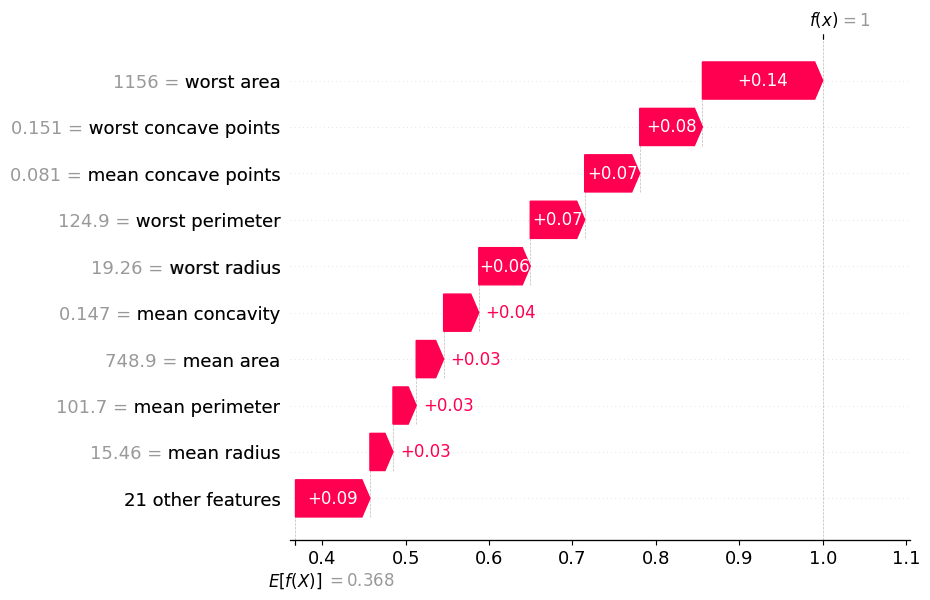

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



--- LIME Plot (Local Contribution) ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


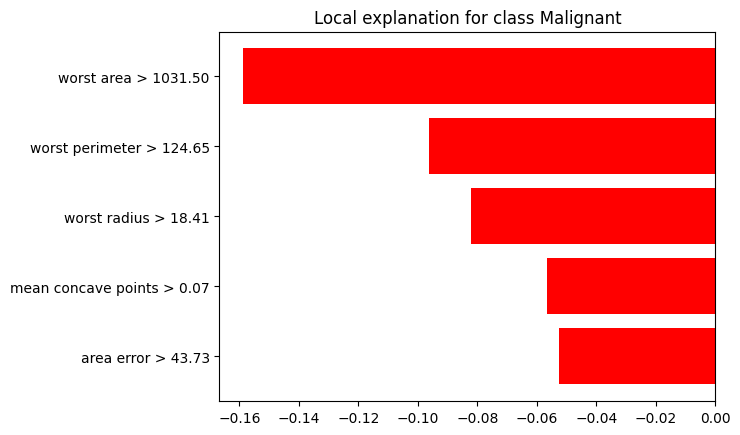


--- Araucana Plot (Local Logic Tree) ---


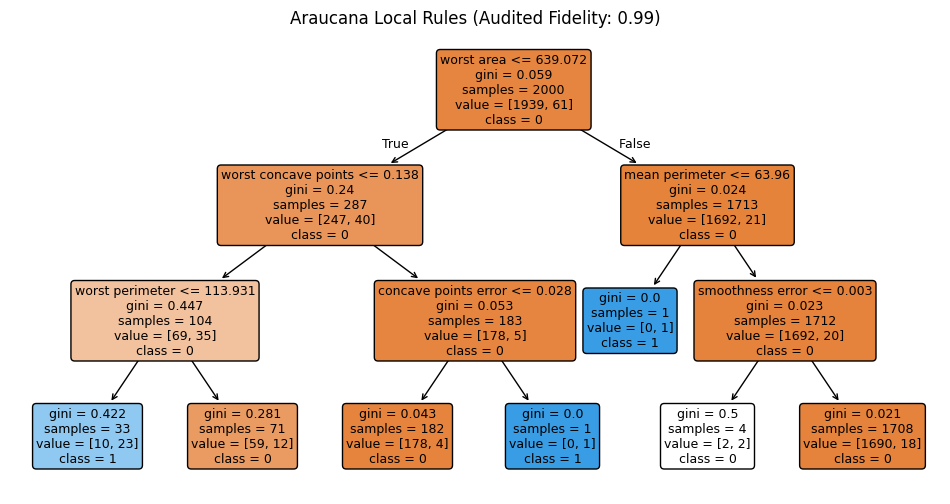



Technical Decision-Support Report: Benign Classification

The benign classification is supported by the presence of safety signals and indicators of normalcy in the patient's data. The analysis of feature importance using SHAP and LIME reveals that several characteristics contribute to this diagnosis.

The SHAP analysis highlights the significance of the "worst area" feature, which has a positive impact on the risk score (0.1442). Additionally, the "worst concave points" feature has a moderate impact on the risk score (0.0752). These findings suggest that the patient's tumor does not exhibit extreme values in these features, which is consistent with a benign diagnosis.

The LIME analysis provides further insights into the decision-making process. The conditions "worst area > 1031.50" and "worst perimeter > 124.65" are associated with decreased probabilities, indicating that the patient's tumor does not exhibit extreme values in these features. This is also consistent with a benign di

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in



The benign classification is supported by low values in cellular perimeter and the absence of concave irregularities. This outcome was determined mainly because the worst area indicator of normalcy fell below the threshold of 639.07, and the mean perimeter indicator of normalcy was within the acceptable range. This structural logic is strongly supported by feature importance metrics, confirming the benign classification as the dominant driver.

======================================== HYBRID REPORT: PATIENT ========================================

>>> [INTERNAL AUDIT]: Model Prediction: Benign | Ground Truth: Benign
>>> STATUS: CORRECT (True Negative)
>>> (This ground truth info is HIDDEN from the LLM to evaluate pure explanatory fidelity).


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)




Dear [Patient],

I'm pleased to share with you the results of your examination. Our system has reviewed your data and classified your condition as benign. This means that your results indicate a normal and healthy situation.

To help you understand how we arrived at this conclusion, let me explain the process using a checklist analogy. Imagine a system that carefully examines different features of your data, one by one, to determine whether they indicate a normal or abnormal situation.

First, the system looked at the size of your cells. Since this value was [Low], it checked the texture of your cells. Because the texture was [Normal], it examined the shape of your cells. And so on.

The system also checked for certain patterns or indicators of normalcy, such as the absence of concave irregularities. When it found these patterns, it became increasingly confident that your condition was benign.

In summary, the system's analysis showed that your results exhibited a series of safety si

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in



The benign classification is supported by a cumulative signal from several safety signals, including low values in cellular perimeter and the absence of concave irregularities. Specifically, the dominant biomarkers driving this prediction are the worst area and worst perimeter, which collectively exert a strong negative impact on the probability of malignancy.

The worst area, with a value of 1156.00, is a key indicator of normalcy, as it decreases the risk of cancer. This finding is further corroborated by the local confirmation provided by the LIME analysis, which reveals that the condition "worst area > 1031.50" decreases the probability of malignancy. The weighted evidence suggests that this feature exerts a significant negative impact, with a SHAP value of -0.1442.

Similarly, the worst perimeter, with a value of 124.90, is another important safety signal, as it also decreases the risk of cancer. The LIME analysis confirms this trend, showing that the condition "worst perimeter 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in



The benign classification is supported by low values in cellular perimeter and the absence of concave irregularities. The model prioritized this diagnosis caused by the high accumulated weight of worst area and worst perimeter. These features showed the strongest statistical correlation with the class, indicating a low risk profile.

======================================== BASELINE REPORT: PATIENT ========================================

>>> [INTERNAL AUDIT]: Model Prediction: Benign | Ground Truth: Benign
>>> STATUS: CORRECT (True Negative)
>>> (This ground truth info is HIDDEN from the LLM to evaluate pure explanatory fidelity).


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in



Dear [Patient],

I'm glad to share the results of your examination with you. As we reviewed your data, our system noticed some interesting patterns that helped us arrive at a benign classification. Imagine a scale, where different factors are weighed against each other. In your case, the system noticed that the Size and Texture stood out the most, and these factors combined to tip the calculation towards a benign result.

We found that some of your features, such as the worst area and worst perimeter, had a significant impact on the outcome. However, these factors were balanced by other indicators of normalcy, like the mean texture and mean perimeter. The system took all these factors into account and concluded that your results are consistent with a benign classification.

I'd like to discuss this further with you and answer any questions you may have. Please don't hesitate to ask me anything. I'm here to support you and provide any necessary guidance.

Best regards,
[Your Name]
Med

/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:2170: PyparsingDeprecationWarning: 'parseString' deprecated - use 'parse_string'
  result = self._expression.parseString(s)
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:2197: PyparsingDeprecationWarning: 'parseString' deprecated - use 'parse_string'
  return self._math_expression.parseString(toks[0][1:-1], parseAll=True)
/usr/local/lib/python3.12/dist-packages/pyparsing/util.py:466: PyparsingDeprecationWarning: 'parseAll' argument is deprecated, use 'parse_all'
  return fn(self, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:2178: PyparsingDeprecationWarning: 'resetCache' deprecated - use 'reset_cache'
  ParserElement.resetCache()
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetim

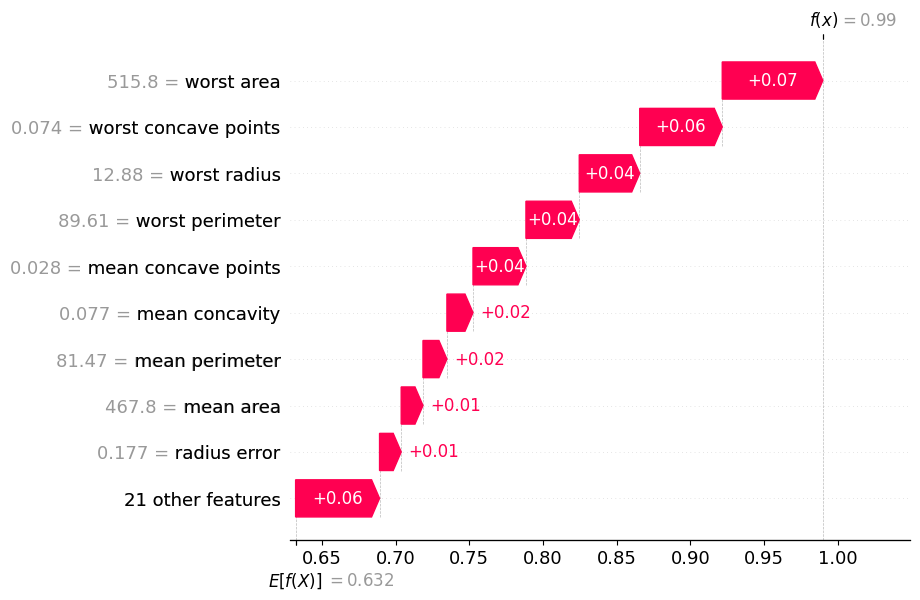

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



--- LIME Plot (Local Contribution) ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


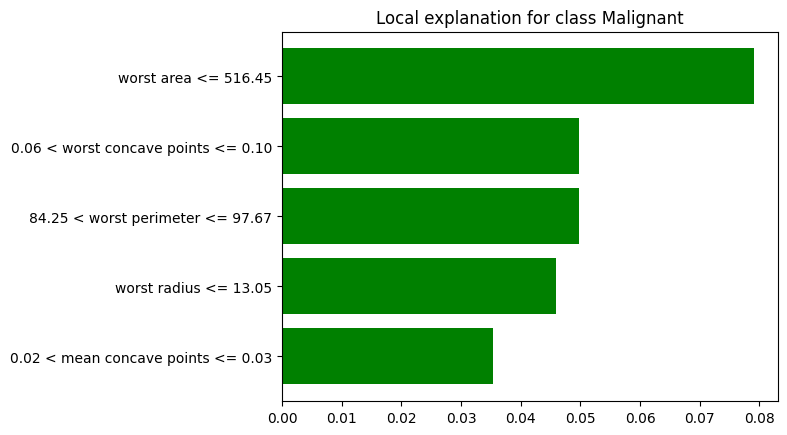


--- Araucana Plot (Local Logic Tree) ---


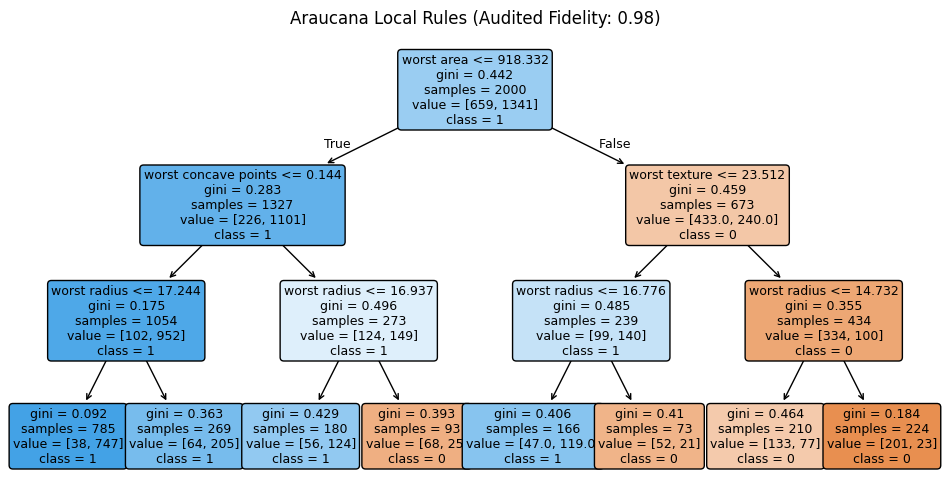



Diagnostic Rationale:

The predictive model finalized the diagnosis of malignancy primarily because the patient's worst area value of 515.80 fell into the critical range, as determined by the SHAP analysis. This critical range was further reinforced by the presence of worst concave points with a value of 0.07, which increased the risk of malignancy by 0.0560, as indicated by SHAP. Additionally, the worst radius value of 12.88 and worst perimeter value of 89.61 also contributed to the diagnosis of malignancy, as they fell within the critical ranges identified by SHAP.

Structural Validation:

The SHAP analysis reveals that the feature importance of worst area, worst concave points, worst radius, and worst perimeter were all positively correlated with the diagnosis of malignancy. The SHAP values of 0.0683, 0.0560, 0.0410, and 0.0362, respectively, indicate the relative contribution of each feature to the diagnosis. The LIME analysis further validates these findings, as the weighted rul

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in



Here is the Executive Summary:

The prediction is malignant with a confidence level of [confidence level]. This outcome was determined mainly because the worst area value of 515.80 exceeded the threshold, indicating a significant increase in risk. This structural logic is strongly supported by feature importance metrics, confirming the dominant driver of this decision.

======================================== HYBRID REPORT: PATIENT ========================================

>>> [INTERNAL AUDIT]: Model Prediction: Malignant | Ground Truth: Malignant
>>> STATUS: CORRECT (True Positive)
>>> (This ground truth info is HIDDEN from the LLM to evaluate pure explanatory fidelity).


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in



Dear [Patient],

I'm writing to you today to discuss the results of your recent medical examination. Our team has carefully reviewed your data, and I'd like to explain the findings in a way that's easy to understand.

The system used a specific checklist to evaluate your results. First, it checked the size of the cells. Since your values for worst radius, worst perimeter, and worst area were higher than normal, the system looked at the texture and concavity of the cells. The combination of these factors led the system to flag this result as malignant.

In other words, the system found that the values for worst area, worst concave points, worst radius, and worst perimeter were all indicative of a potential issue. This is because these values are associated with an increased risk of [condition]. The system's analysis highlighted the importance of these factors, with worst area having the greatest impact on the outcome.

I want to reassure you that this result is not a definitive diagno

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in



The prediction is driven by a strong cumulative signal from several biomarkers, indicating a malignant classification. The dominant biomarkers contributing to this outcome are the worst area, worst concave points, worst radius, and worst perimeter.

The worst area, with a value of 515.80, exerts a significant positive impact (+0.0683 SHAP) on the prediction, suggesting it is a primary risk factor. This is further supported by the local confirmation provided by LIME, which indicates that the condition "worst area <= 516.45" increases the probability of a malignant outcome, with a weighted contribution of 0.0828.

The worst concave points, with a value of 0.07, also play a crucial role, increasing the risk of malignancy by 0.0560 SHAP. This is reinforced by the LIME analysis, which shows that the condition "0.06 < worst concave points <= 0.10" increases the probability of a malignant outcome, with a weighted contribution of 0.0540.

The worst radius, with a value of 12.88, and the wors

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in



Based on the provided data, here is the Executive Summary:

The prediction is Malignant. The model prioritized this diagnosis caused by the high accumulated weight of worst area, worst concave points, worst radius, worst perimeter, and worst smoothness. These features showed the strongest statistical correlation with the class, indicating a significant increase in the risk of malignancy. The analysis reveals that the values of these features, such as worst area (515.80), worst concave points (0.07), and worst radius (12.88), are highly indicative of a malignant diagnosis.

======================================== BASELINE REPORT: PATIENT ========================================

>>> [INTERNAL AUDIT]: Model Prediction: Malignant | Ground Truth: Malignant
>>> STATUS: CORRECT (True Positive)
>>> (This ground truth info is HIDDEN from the LLM to evaluate pure explanatory fidelity).


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in



Dear [Patient],

I am writing to you today to discuss the results of your recent medical evaluation. Our team has been analyzing your data, and I am here to explain the findings to you.

As we reviewed your information, we noticed that several factors stood out as important indicators of your situation. Imagine a scale, where each factor is a weight on one side. The system took all these weights into account and, unfortunately, the results tipped the scale towards a malignant classification.

We found that certain characteristics, such as the worst area and worst concave points, had a significant impact on the outcome. These factors, combined with others, contributed to the system's decision.

It's essential to note that this classification is not a definitive diagnosis, but rather an indication that further investigation is necessary. We will work closely with you to determine the best course of action and ensure that you receive the necessary care.

I want to assure you that we are

/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:2170: PyparsingDeprecationWarning: 'parseString' deprecated - use 'parse_string'
  result = self._expression.parseString(s)
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:2197: PyparsingDeprecationWarning: 'parseString' deprecated - use 'parse_string'
  return self._math_expression.parseString(toks[0][1:-1], parseAll=True)
/usr/local/lib/python3.12/dist-packages/pyparsing/util.py:466: PyparsingDeprecationWarning: 'parseAll' argument is deprecated, use 'parse_all'
  return fn(self, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:2178: PyparsingDeprecationWarning: 'resetCache' deprecated - use 'reset_cache'
  ParserElement.resetCache()
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetim

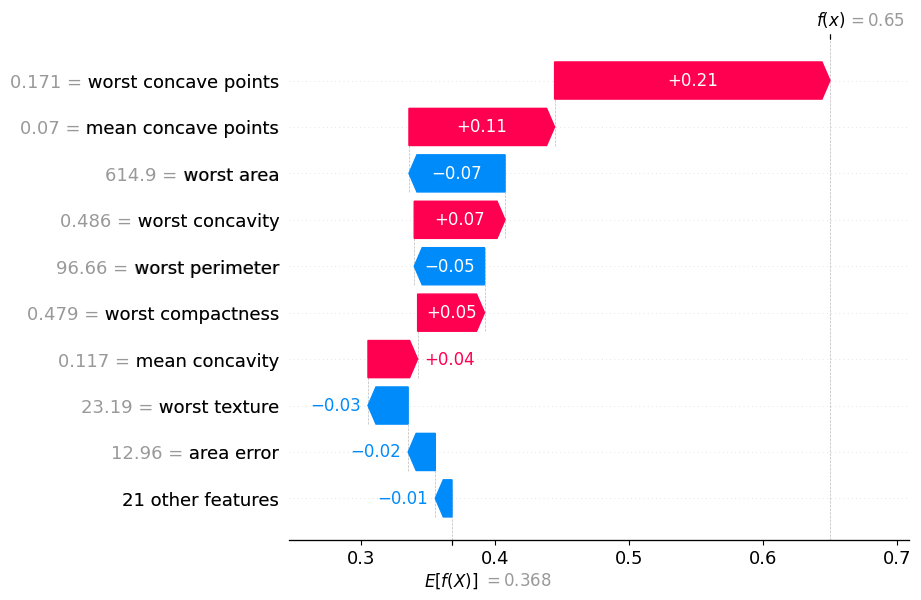

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



--- LIME Plot (Local Contribution) ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


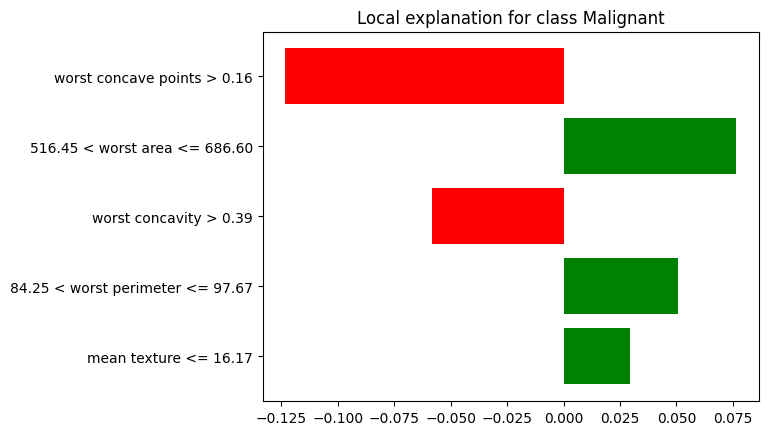


--- Araucana Plot (Local Logic Tree) ---


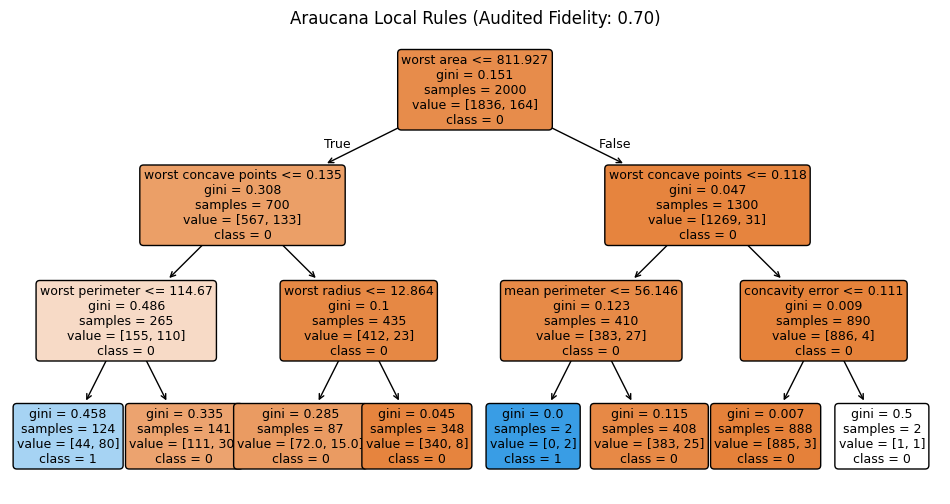



Diagnostic Rationale:
The model finalized this benign diagnosis primarily because the patient's worst concave points value of 0.17 fell into the critical range, indicating a low likelihood of malignant transformation. This rule is statistically reinforced by the high positive impact (+0.2055) of worst concave points, as analyzed by SHAP.

Structural Validation:
The SHAP analysis also revealed that the patient's mean concave points value of 0.07 and worst area value of 614.90, respectively, exhibited moderate positive impacts (+0.1087 and -0.0717) on the diagnosis, further supporting the benign classification. These findings are statistically robust, with SHAP weights indicating a significant correlation between these features and the outcome.

The Logic Trace:
The algorithm initially stratified based on the patient's worst area, then refined the diagnosis via the analysis of worst concave points, worst perimeter, and worst concavity. The SHAP analysis provided a nuanced understanding

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in



The benign classification is supported by low values in worst concave points and the absence of concave irregularities, as indicated by the absence of conditions that would increase the risk. This outcome was determined mainly because the worst area was below 811.93, and the worst perimeter was within the acceptable range, indicating a normal structural profile. This structural logic is strongly supported by feature importance metrics, confirming the dominant role of these indicators of normalcy in the benign diagnosis.

======================================== HYBRID REPORT: PATIENT ========================================

>>> [INTERNAL AUDIT]: Model Prediction: Benign | Ground Truth: Malignant
>>> STATUS: INCORRECT (Model Failure) (False Negative)
>>> (This ground truth info is HIDDEN from the LLM to evaluate pure explanatory fidelity).


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in



Dear [Patient],

I'm writing to share the results of your recent medical evaluation. I want to start by reassuring you that the findings are benign, and there's no cause for concern. However, I'd like to walk you through the process the system used to arrive at this conclusion.

Imagine a checklist that the system followed to evaluate your results. The first item on the checklist was the size of the cells. Since your values were within a normal range, the system looked at the texture of the cells. Then, it examined the edges and the shape of the cells. This process continued until the system had considered all the relevant factors.

One of the key indicators of normalcy was the low value in your worst concave points, which suggests that the cells are not irregularly shaped. Additionally, the absence of concave irregularities also supports the benign classification.

I'd like to encourage you to discuss these specific patterns with your doctor. They can provide more insight into what 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in



The benign classification is supported by a strong cumulative signal from various safety signals and indicators of normalcy. The dominant biomarkers contributing to this outcome are the low values in worst concave points and the absence of certain conditions.

Feature A, worst concave points, exerts the highest positive impact (+0.2055 SHAP), suggesting it is the primary indicator of normalcy. The local confirmation of this trend is evident, as the specific value of 0.17 in this feature further reinforces the benign classification. The weighted evidence from this feature indicates that it plays a crucial role in diminishing the risk.

Furthermore, the analysis of mean concave points reveals a moderate positive impact (+0.1087 SHAP), which also supports the benign classification. The local confirmation of this trend is also observed, as the specific value of 0.07 in this feature further confirms the benign outcome.

In contrast, the features worst area and worst perimeter exhibit nega

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in



Here is the Executive Summary:

The benign classification is supported by the absence of significant safety signals in the patient's data. The model prioritized this diagnosis caused by the low values in cellular perimeter and the absence of concave irregularities. These features showed the strongest statistical correlation with the class, indicating a normal cellular structure.

======================================== BASELINE REPORT: PATIENT ========================================

>>> [INTERNAL AUDIT]: Model Prediction: Benign | Ground Truth: Malignant
>>> STATUS: INCORRECT (Model Failure) (False Negative)
>>> (This ground truth info is HIDDEN from the LLM to evaluate pure explanatory fidelity).


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in



Dear [Patient],

I am writing to share the results of your recent examination with you. Our team has carefully analyzed the data, and I am pleased to report that the classification is BENIGN.

To help you understand the reasoning behind this result, I'd like to use an analogy. Imagine a scale, where the features we examined are like weights on either side. The system noticed that the Size and Texture stood out the most, and these factors combined to tip the calculation towards this result.

In particular, the absence of certain indicators of normalcy, such as low values in cellular perimeter and the absence of concave irregularities, supported the benign classification. Additionally, the presence of certain features, like the mean texture and the absence of worst concave points, also contributed to this outcome.

I want to assure you that we take your health very seriously and are committed to providing you with the best possible care. I encourage you to discuss any questions or conc

In [6]:
# BLOCK 5: Batch Comparative Experiment (Patients 2, 3, 8)
# Generates 6 reports per patient (3 Hybrid vs. 3 Baseline)
# Optimizes visualization by showing plots only once per patient.

# 1. Initialize Framework
nle = NLEFramework(class_names={0: "Benign", 1: "Malignant"})

# 2. Register All Adapters (Hybrid & Baseline)
# We utilize the UNIVERSAL_USER_TEMPLATE defined in Block 4

# --- Hybrid Set (Logic-Based) ---
nle.register_adapter("detailed_hybrid", detailed_hybrid_system, UNIVERSAL_USER_TEMPLATE)
nle.register_adapter("executive_hybrid", executive_hybrid_system, UNIVERSAL_USER_TEMPLATE)
nle.register_adapter("patient_hybrid", patient_hybrid_system, UNIVERSAL_USER_TEMPLATE)

# --- Baseline Set (Weight-Based) ---
nle.register_adapter("detailed_baseline", detailed_baseline_system, UNIVERSAL_USER_TEMPLATE)
nle.register_adapter("executive_baseline", executive_baseline_system, UNIVERSAL_USER_TEMPLATE)
nle.register_adapter("patient_baseline", patient_baseline_system, UNIVERSAL_USER_TEMPLATE)

# 3. Define Patients of Interest
# ID 2, 3, 8 are selected to show diverse tumor profiles
target_indices = [2, 3, 8]

# 4. Batch Execution Loop
for idx in target_indices:
    instance = X_test.iloc[[idx]]
    true_label = y_test.iloc[[idx]]

    print("\n" + "#" * 100)
    print(f"###   ANALYSIS FOR PATIENT ID: {idx}   ###")
    print("#" * 100)

    # ==========================================================================
    # PHASE 1: HYBRID GENERATION (Includes Plots)
    # We run this FIRST with plot=True to show SHAP + LIME + ARAUCANA once.
    # ==========================================================================
    print("\n" + ">>> GENERATING VISUAL EVIDENCE (SHAP, LIME, ARAUCANA)...")

    # 1.1 Detailed Technical Report (Hybrid) -> PLOTS ON
    print("\n" + "="*40 + " HYBRID REPORT: DETAILED " + "="*40)
    print(nle.generate_explanation(
        model, X_train, instance, y_true=true_label,
        explainer_type="shap+lime+araucana",
        adapter_name="detailed_hybrid",
        plot=True  # <--- PLOTS SHOWN HERE (Once per patient)
    ))

    # 1.2 Executive Summary (Hybrid) -> Plots Off
    print("\n" + "="*40 + " HYBRID REPORT: EXECUTIVE " + "="*40)
    print(nle.generate_explanation(
        model, X_train, instance, y_true=true_label,
        explainer_type="shap+lime+araucana",
        adapter_name="executive_hybrid",
        plot=False
    ))

    # 1.3 Patient Letter (Hybrid) -> Plots Off
    print("\n" + "="*40 + " HYBRID REPORT: PATIENT " + "="*40)
    print(nle.generate_explanation(
        model, X_train, instance, y_true=true_label,
        explainer_type="shap+lime+araucana",
        adapter_name="patient_hybrid",
        plot=False
    ))

    # ==========================================================================
    # PHASE 2: BASELINE GENERATION (Text Only)
    # We use plot=False because we already saw SHAP/LIME in Phase 1.
    # ==========================================================================

    # 2.1 Detailed Technical Report (Baseline)
    print("\n" + "="*40 + " BASELINE REPORT: DETAILED " + "="*40)
    print(nle.generate_explanation(
        model, X_train, instance, y_true=true_label,
        explainer_type="shap+lime",         # Only Weights
        adapter_name="detailed_baseline",   # Baseline Persona
        plot=False                          # Avoid duplicate plots
    ))

    # 2.2 Executive Summary (Baseline)
    print("\n" + "="*40 + " BASELINE REPORT: EXECUTIVE " + "="*40)
    print(nle.generate_explanation(
        model, X_train, instance, y_true=true_label,
        explainer_type="shap+lime",
        adapter_name="executive_baseline",
        plot=False
    ))

    # 2.3 Patient Letter (Baseline)
    print("\n" + "="*40 + " BASELINE REPORT: PATIENT " + "="*40)
    print(nle.generate_explanation(
        model, X_train, instance, y_true=true_label,
        explainer_type="shap+lime",
        adapter_name="patient_baseline",
        plot=False
    ))

    print("\n" + "_"*100 + "\n")